In [ ]:
!pip install split-folders

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import drive
import zipfile
import splitfolders
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
#---------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
#---------------------------------------
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#---------------------------------------
import warnings
warnings.filterwarnings("ignore")

In [ ]:
zip_file_path = '/content/drive/MyDrive/Colab Notebooks/digit_21.zip'
destination_folder = '/content'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(destination_folder)
print("Extraction completed.")

Extraction completed.


In [ ]:
import splitfolders

input_folder = '/content/digit_21'
output_folder = '/content/split_dataset'
splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(0.8, 0.2), group_prefix=None)

print("Dataset split completed.")

Copying files: 30687 files [00:10, 3057.85 files/s]

Dataset split completed.


In [ ]:
def train_df(tr_path):
    classes, class_paths = zip(*[(label, os.path.join(tr_path, label, image))
                                 for label in os.listdir(tr_path) if os.path.isdir(os.path.join(tr_path, label))
                                 for image in os.listdir(os.path.join(tr_path, label))])

    tr_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return tr_df

In [ ]:
def test_df(ts_path):
    classes, class_paths = zip(*[(label, os.path.join(ts_path, label, image))
                                 for label in os.listdir(ts_path) if os.path.isdir(os.path.join(ts_path, label))
                                 for image in os.listdir(os.path.join(ts_path, label))])

    ts_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return ts_df

In [ ]:
tr_df = train_df('/content/split_dataset/train')
tr_df

,Class Path,Class
0,/content/split_dataset/train/5/0_LAKS_14_1_118...,5
1,/content/split_dataset/train/5/1_BAR_13_1_423.jpg,5
2,/content/split_dataset/train/5/0_COM_16_1_557.jpg,5
3,/content/split_dataset/train/5/1_MUN_12_1_1265...,5
4,/content/split_dataset/train/5/0_DHA_16_1_953.jpg,5
...,...,...
24541,/content/split_dataset/train/9/1_DHA_13_1_839.jpg,9
24542,/content/split_dataset/train/9/1_NOA_12_1_274.jpg,9
24543,/content/split_dataset/train/9/1_TAN_11_1_1557...,9
24544,/content/split_dataset/train/9/1_Ran_21_3_0002...,9


In [ ]:
ts_df = test_df('/content/split_dataset/val')
ts_df

,Class Path,Class
0,/content/split_dataset/val/5/1_BAR_15_1_457.jpg,5
1,/content/split_dataset/val/5/1_Cand_20_3_00076...,5
2,/content/split_dataset/val/5/1_CHAD_11_1_502.jpg,5
3,/content/split_dataset/val/5/0_NET_14_1_1316.jpg,5
4,/content/split_dataset/val/5/1_BAR_13_1_430.jpg,5
...,...,...
6136,/content/split_dataset/val/9/1_DHA_11_1_666.jpg,9
6137,/content/split_dataset/val/9/1_DHA_9_1_1016.jpg,9
6138,/content/split_dataset/val/9/0_TAN_18_2_1482.jpg,9
6139,/content/split_dataset/val/9/0_KUSH_17_2_1171.jpg,9


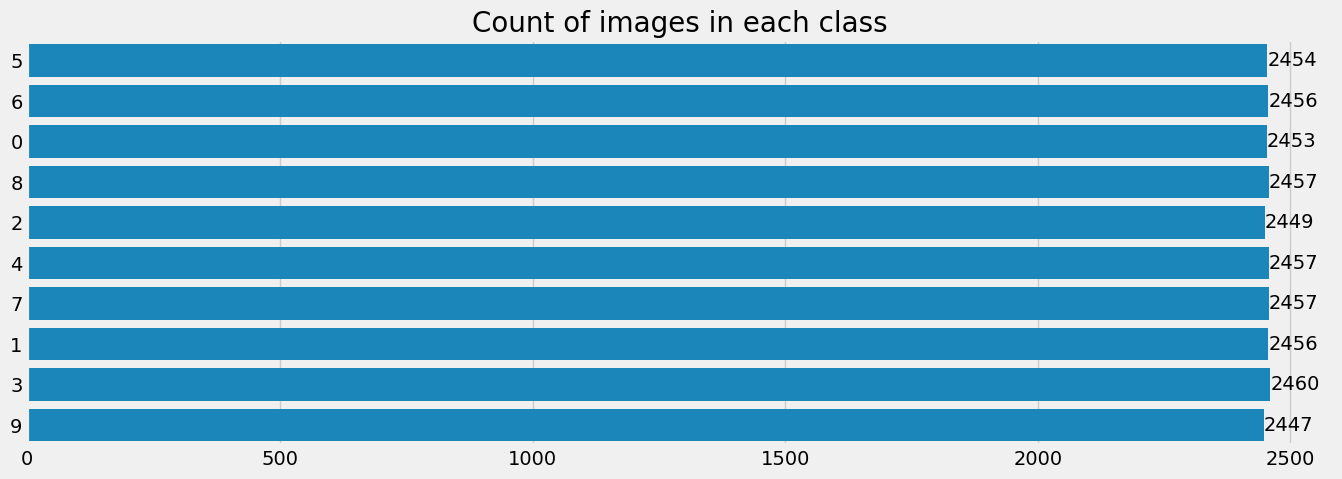

In [ ]:
# Count of images in each class in train data
plt.figure(figsize=(15,5))
ax = sns.countplot(data=tr_df , y=tr_df['Class'])

plt.xlabel('')
plt.ylabel('')
plt.title('Count of images in each class', fontsize=20)
ax.bar_label(ax.containers[0])
plt.show()

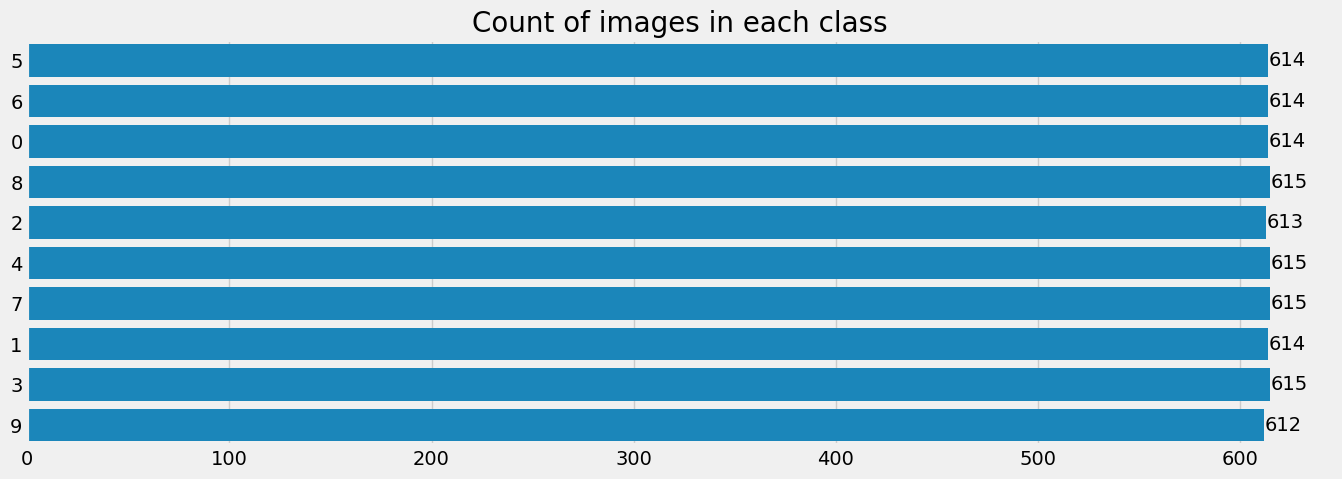

In [ ]:
#Count each class in test data
plt.figure(figsize=(15,5))
ax = sns.countplot(data=ts_df , y=ts_df['Class'])

plt.xlabel('')
plt.ylabel('')
plt.title('Count of images in each class', fontsize=20)
ax.bar_label(ax.containers[0])
plt.show()

In [ ]:
valid_df, ts_df = train_test_split(ts_df, train_size=0.5, random_state=20, stratify=ts_df['Class'])
valid_df

,Class Path,Class
4114,/content/split_dataset/val/7/0_DHA_16_1_911.jpg,7
2008,/content/split_dataset/val/8/0_TAN_21_3_332.jpg,8
5560,/content/split_dataset/val/9/1_NOA_11_1_1354.jpg,9
2385,/content/split_dataset/val/8/0_JES_16_2_1130.jpg,8
277,/content/split_dataset/val/5/0_KIS_15_1_1157.jpg,5
...,...,...
257,/content/split_dataset/val/5/1_GOP_12_1_1093.jpg,5
5923,/content/split_dataset/val/9/1_DHA_14_1_943.jpg,9
2158,/content/split_dataset/val/8/0_DHA_14_1_811.jpg,8
3306,/content/split_dataset/val/4/0_DHA_13_1_767.jpg,4


In [ ]:
batch_size = 32
img_size = (71, 71)

_gen = ImageDataGenerator(rescale=1/255,
                          brightness_range=(0.8, 1.2))

ts_gen = ImageDataGenerator(rescale=1/255)


tr_gen = _gen.flow_from_dataframe(tr_df, x_col='Class Path',
                                  y_col='Class', batch_size=batch_size,
                                  target_size=img_size)

valid_gen = _gen.flow_from_dataframe(valid_df, x_col='Class Path',
                                     y_col='Class', batch_size=batch_size,
                                     target_size=img_size)

ts_gen = ts_gen.flow_from_dataframe(ts_df, x_col='Class Path',
                                  y_col='Class', batch_size=16,
                                  target_size=img_size, shuffle=False)

Found 24546 validated image filenames belonging to 10 classes.
Found 3070 validated image filenames belonging to 10 classes.
Found 3071 validated image filenames belonging to 10 classes.


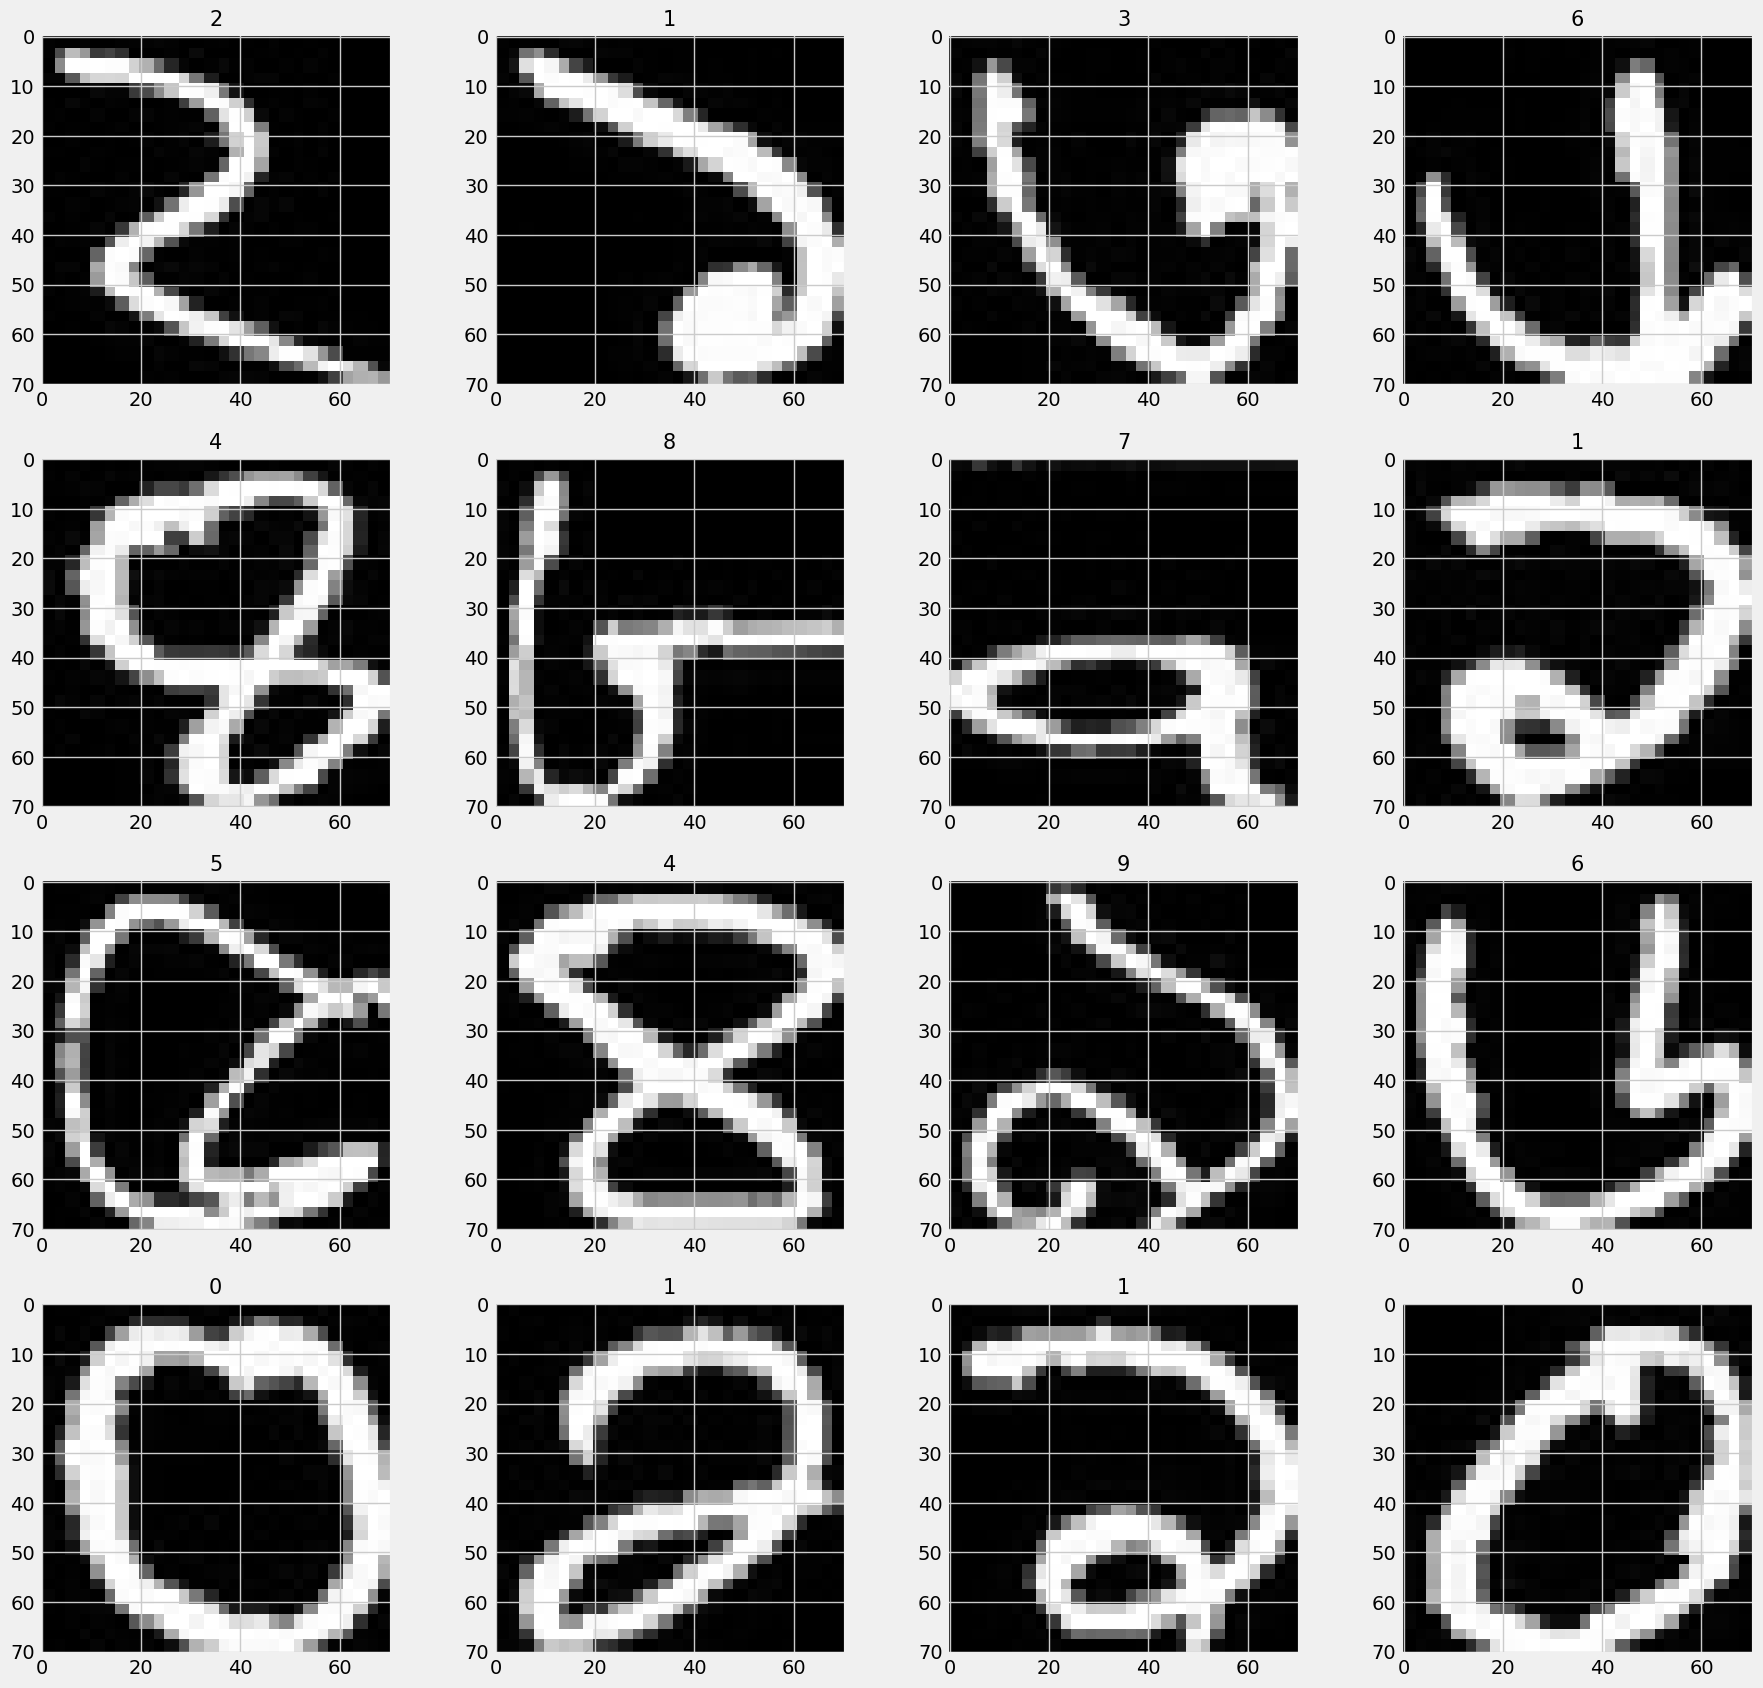

In [ ]:
class_dict = tr_gen.class_indices
classes = list(class_dict.keys())
images, labels = next(ts_gen)

plt.figure(figsize=(20, 20))

for i, (image, label) in enumerate(zip(images, labels)):
    plt.subplot(4,4, i + 1)
    plt.imshow(image)
    class_name = classes[np.argmax(label)]
    plt.title(class_name, color='k', fontsize=15)

plt.show()

# ***Building Deep Learning Model***

In [ ]:

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Flatten, Dropout, Dense
from tensorflow.keras.models import Sequential

img_shape = (71, 71, 3)

# Load the ResNet50 base model
base_model_resnet = ResNet50(include_top=False, weights='imagenet', input_shape=img_shape, pooling='max')

num_classes = 10

# Define the model architecture
model_resnet = Sequential([
    base_model_resnet,
    Flatten(),
    Dropout(rate=0.3),
    Dense(128, activation='relu'),
    Dropout(rate=0.25),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model_resnet.compile(
    optimizer='adam',  # You can choose any optimizer
    loss='categorical_crossentropy',
    metrics=['accuracy', 'Precision', 'Recall']
)

# Print model summary
model_resnet.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               262272    
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 10)                1290      
                                                                 
Total params: 23851274 (90.99 MB)
Trainable params: 23

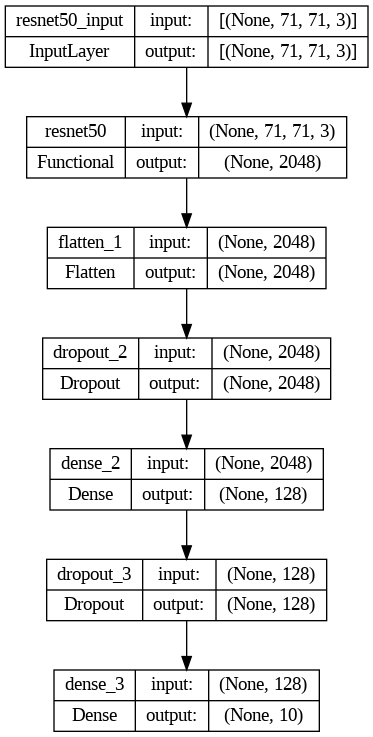

In [ ]:
tf.keras.utils.plot_model(model_resnet, show_shapes=True)

In [ ]:
hist = model_resnet.fit(tr_gen,
                 epochs=6,
                 batch_size=32,
                 validation_data=valid_gen,
                 shuffle= False)

Epoch 1/6
768/768 [==============================] - 107s 90ms/step - loss: 0.4303 - accuracy: 0.8970 - precision: 0.9355 - recall: 0.8728 - val_loss: 1.0994 - val_accuracy: 0.6567 - val_precision: 0.7968 - val_recall: 0.4661
Epoch 2/6
768/768 [==============================] - 68s 89ms/step - loss: 0.1922 - accuracy: 0.9531 - precision: 0.9654 - recall: 0.9408 - val_loss: 0.1817 - val_accuracy: 0.9544 - val_precision: 0.9601 - val_recall: 0.9476
Epoch 3/6
768/768 [==============================] - 67s 88ms/step - loss: 0.0903 - accuracy: 0.9782 - precision: 0.9822 - recall: 0.9734 - val_loss: 0.2242 - val_accuracy: 0.9606 - val_precision: 0.9632 - val_recall: 0.9557
Epoch 4/6
768/768 [==============================] - 67s 87ms/step - loss: 0.1359 - accuracy: 0.9664 - precision: 0.9755 - recall: 0.9589 - val_loss: 0.1716 - val_accuracy: 0.9625 - val_precision: 0.9662 - val_recall: 0.9586
Epoch 5/6
768/768 [==============================] - 68s 88ms/step - loss: 0.1098 - accuracy: 0.974

In [ ]:
# model_resnet.save('/content/drive/My Drive/resnet_digit_model.h5')

In [ ]:
hist.history.keys()


dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])

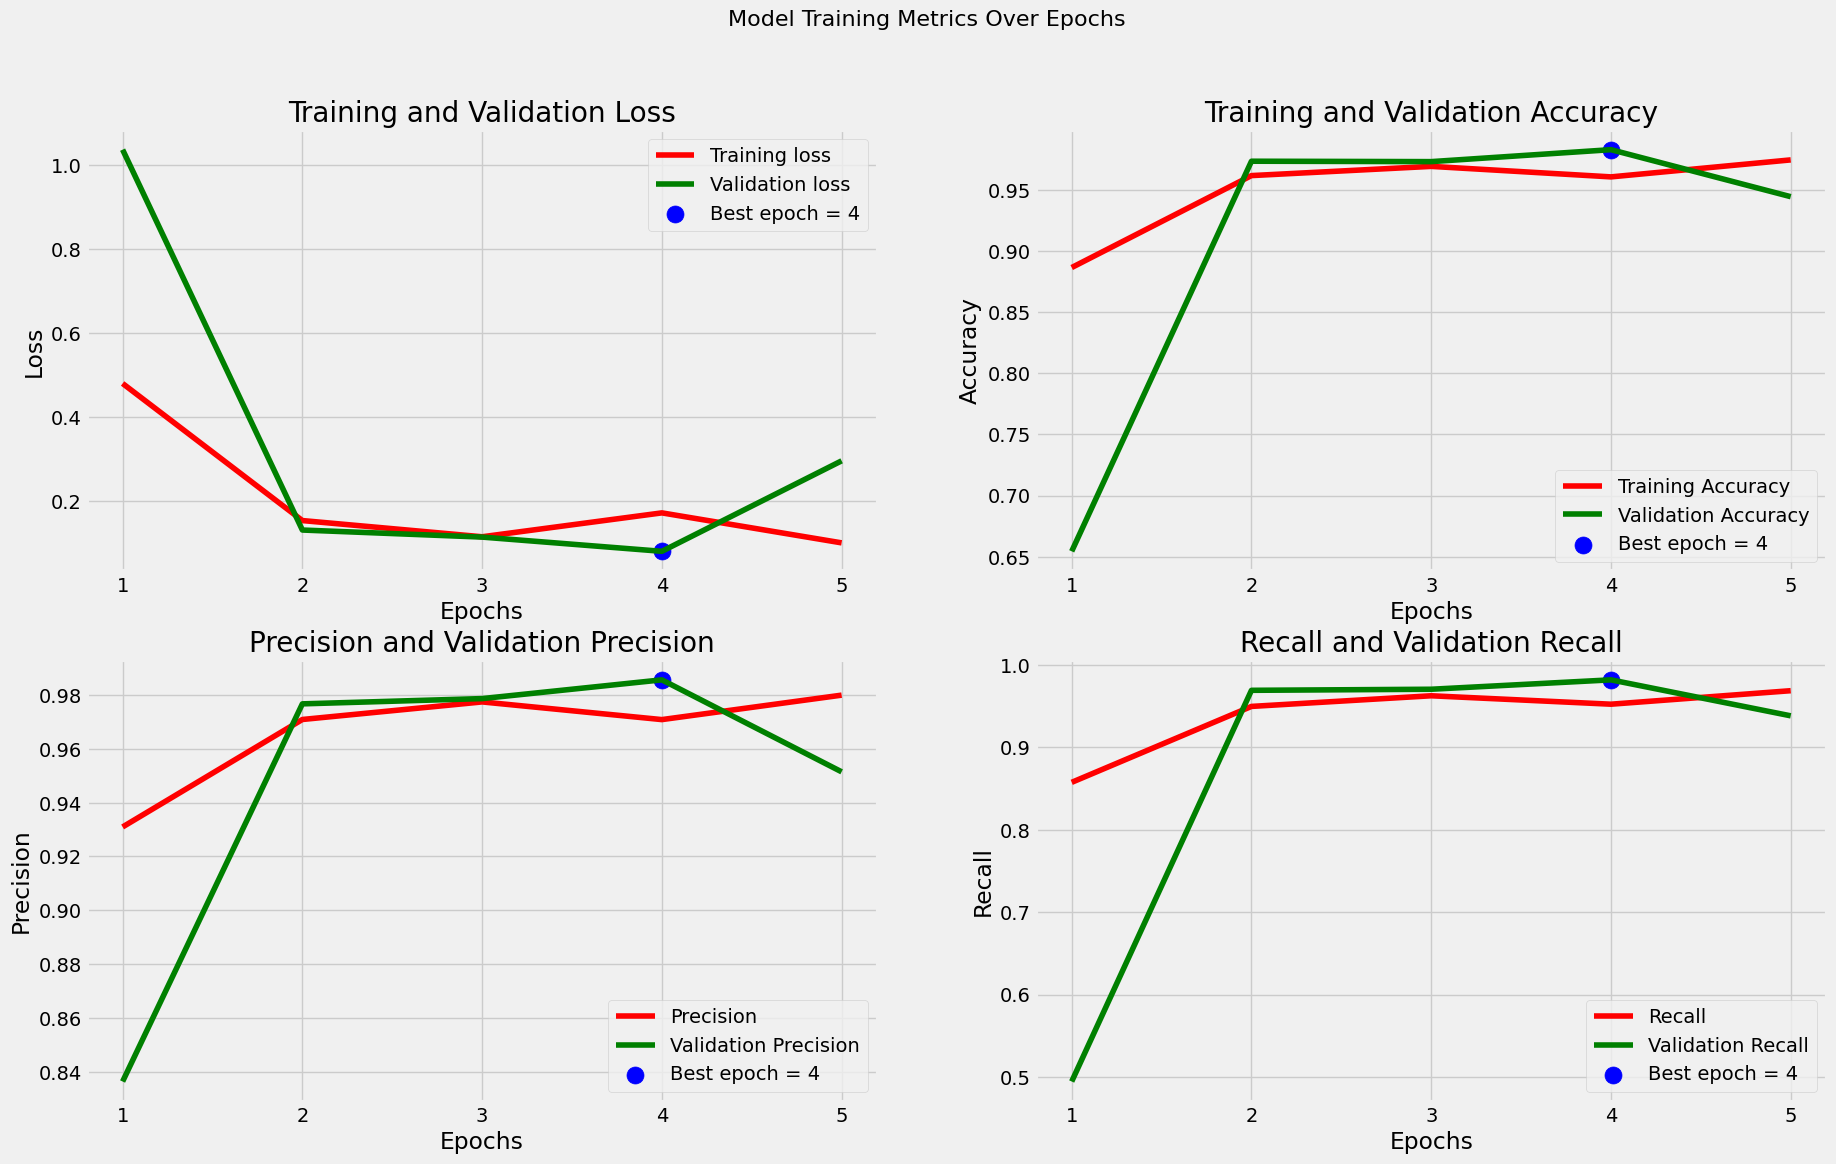

In [ ]:
tr_acc = hist.history['accuracy']
tr_loss = hist.history['loss']
tr_per = hist.history['precision']
tr_recall = hist.history['recall']
val_acc = hist.history['val_accuracy']
val_loss = hist.history['val_loss']
val_per = hist.history['val_precision']
val_recall = hist.history['val_recall']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
index_precision = np.argmax(val_per)
per_highest = val_per[index_precision]
index_recall = np.argmax(val_recall)
recall_highest = val_recall[index_recall]

Epochs = [i + 1 for i in range(len(tr_acc))]
loss_label = f'Best epoch = {str(index_loss + 1)}'
acc_label = f'Best epoch = {str(index_acc + 1)}'
per_label = f'Best epoch = {str(index_precision + 1)}'
recall_label = f'Best epoch = {str(index_recall + 1)}'
plt.figure(figsize=(20, 12))
plt.style.use('fivethirtyeight')

plt.subplot(2, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training loss')
plt.plot(Epochs, val_loss, 'g', label='Validation loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.xticks(np.arange(min(Epochs), max(Epochs)+1, 1.0))

plt.subplot(2, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.xticks(np.arange(min(Epochs), max(Epochs)+1, 1.0))

plt.subplot(2, 2, 3)
plt.plot(Epochs, tr_per, 'r', label='Precision')
plt.plot(Epochs, val_per, 'g', label='Validation Precision')
plt.scatter(index_precision + 1, per_highest, s=150, c='blue', label=per_label)
plt.title('Precision and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.xticks(np.arange(min(Epochs), max(Epochs)+1, 1.0))

plt.subplot(2, 2, 4)
plt.plot(Epochs, tr_recall, 'r', label='Recall')
plt.plot(Epochs, val_recall, 'g', label='Validation Recall')
plt.scatter(index_recall + 1, recall_highest, s=150, c='blue', label=recall_label)
plt.title('Recall and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)
plt.xticks(np.arange(min(Epochs), max(Epochs)+1, 1.0))

plt.suptitle('Model Training Metrics Over Epochs', fontsize=16)

plt.show()


In [ ]:
train_score = model_resnet.evaluate(tr_gen, verbose=1)
valid_score = model_resnet.evaluate(valid_gen, verbose=1)
test_score = model_resnet.evaluate(ts_gen, verbose=1)

print(f"Train Loss: {train_score[0]:.4f}")
print(f"Train Accuracy: {train_score[1]*100:.2f}%")
print('-' * 20)
print(f"Validation Loss: {valid_score[0]:.4f}")
print(f"Validation Accuracy: {valid_score[1]*100:.2f}%")
print('-' * 20)
print(f"Test Loss: {test_score[0]:.4f}")
print(f"Test Accuracy: {test_score[1]*100:.2f}%")

192/192 [==============================] - 5s 28ms/step - loss: 0.1561 - accuracy: 0.9668 - precision: 0.9740 - recall: 0.9642
Train Loss: 0.1364
Train Accuracy: 97.12%
--------------------
Validation Loss: 0.1372
Validation Accuracy: 97.07%
--------------------
Test Loss: 0.1561
Test Accuracy: 96.68%


In [ ]:
preds = model_resnet.predict(ts_gen)
y_pred = np.argmax(preds, axis=1)

192/192 [==============================] - 4s 15ms/step


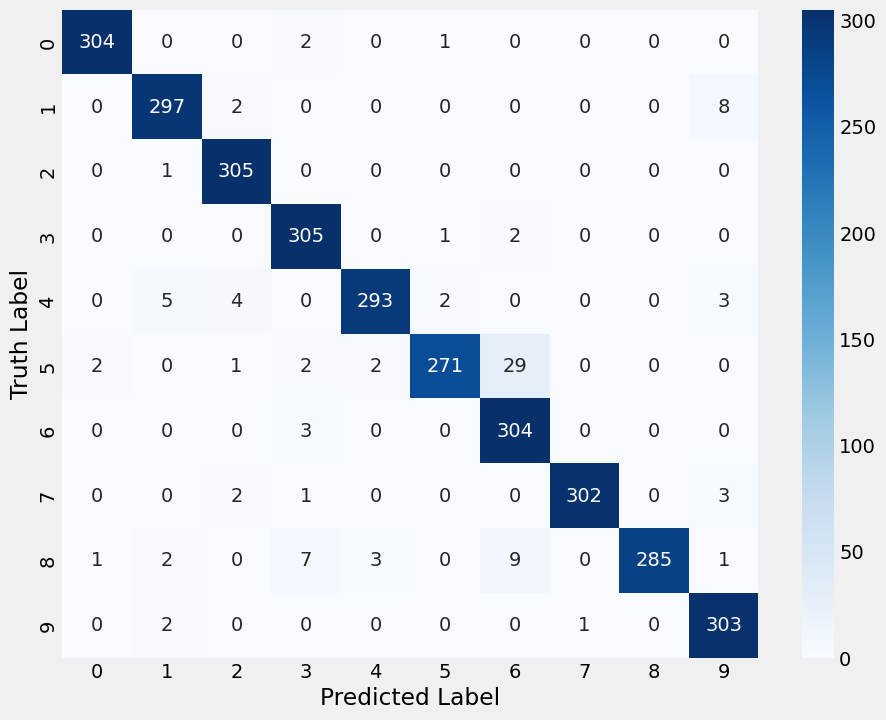

In [ ]:
cm = confusion_matrix(ts_gen.classes, y_pred)
labels = list(class_dict.keys())
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('Truth Label')
plt.show()

In [ ]:
clr = classification_report(ts_gen.classes, y_pred)
print(clr)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       307
           1       0.97      0.97      0.97       307
           2       0.97      1.00      0.98       306
           3       0.95      0.99      0.97       308
           4       0.98      0.95      0.97       307
           5       0.99      0.88      0.93       307
           6       0.88      0.99      0.93       307
           7       1.00      0.98      0.99       308
           8       1.00      0.93      0.96       308
           9       0.95      0.99      0.97       306

    accuracy                           0.97      3071
   macro avg       0.97      0.97      0.97      3071
weighted avg       0.97      0.97      0.97      3071



In [ ]:
def predict(img_path):
    import numpy as np
    import matplotlib.pyplot as plt
    from PIL import Image
    label = list(class_dict.keys())
    plt.figure(figsize=(12, 12))
    img = Image.open(img_path)
    img = img.convert("RGB")
    resized_img = img.resize((71, 71))
    img_array = np.asarray(resized_img)
    img_array = img_array / 255
    img_array = np.expand_dims(img_array, axis=0)
    predictions = model_resnet.predict(img_array)
    probs = list(predictions[0])
    labels = label

    plt.subplot(2, 1, 1)
    plt.imshow(resized_img)

    plt.subplot(2, 1, 2)
    bars = plt.barh(labels, probs)
    plt.xlabel('Probability', fontsize=15)
    ax = plt.gca()
    ax.bar_label(bars, fmt='%.2f')

    plt.show()

1/1 [==============================] - 2s 2s/step


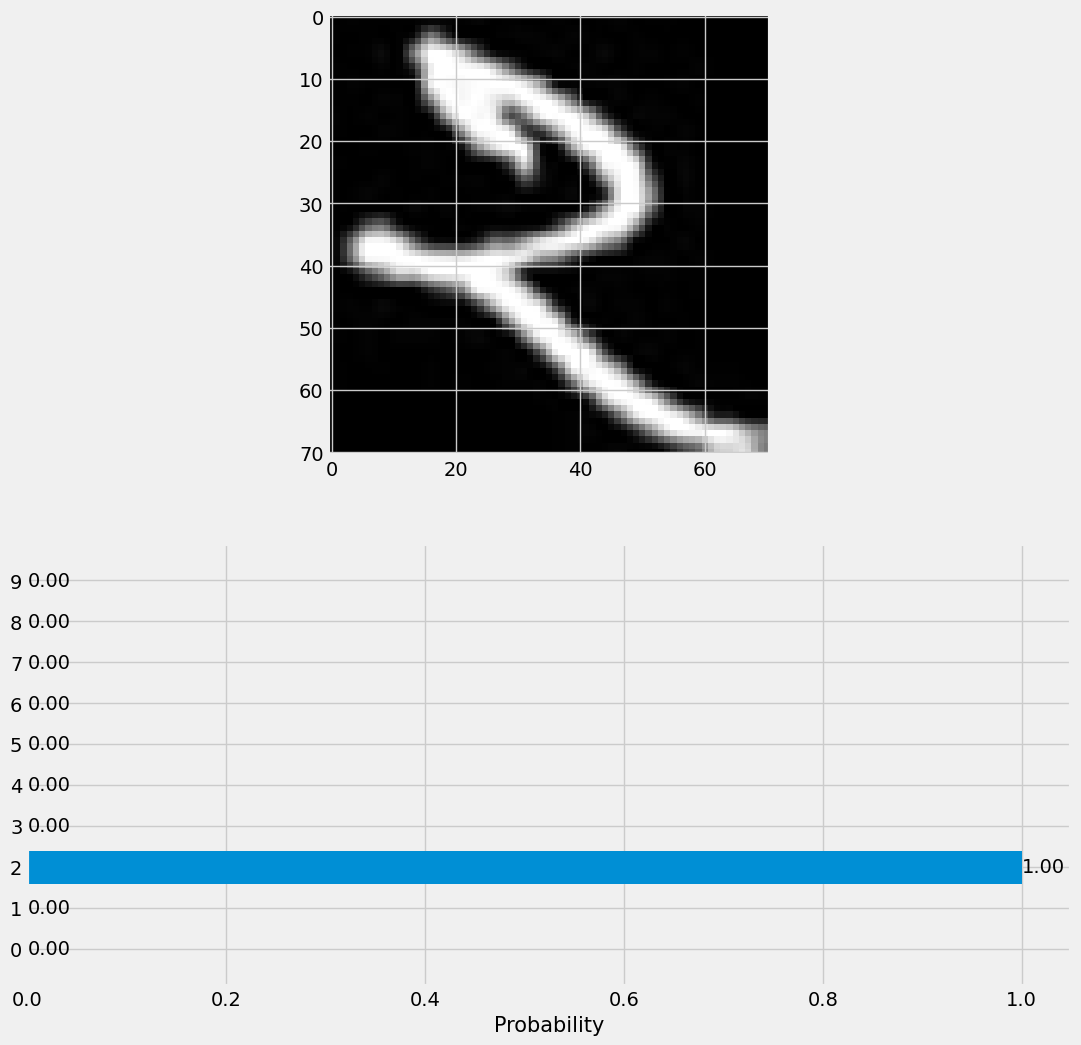

In [ ]:
img_path= '/content/split_dataset/val/2/0_B.BARIA_17_2_363.jpg'
predict(img_path)

# Load Saved Resnet Model

In [ ]:
from keras.models import load_model
saved_resnet_model = load_model('/content/drive/My Drive/resnet_digit_model.h5')

In [ ]:
!pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.8/993.8 kB 5.5 MB/s eta 0:00:00


In [ ]:
import visualkeras

In [ ]:
visualkeras.layered_view(saved_resnet_model)

In [ ]:
saved_resnet_model.add(visualkeras.SpacingDummyLayer(spacing=100))

In [ ]:
batch_size = 32
img_size = (28, 28)

_gen = ImageDataGenerator(rescale=1/255,
                          brightness_range=(0.8, 1.2))

ts_gen = ImageDataGenerator(rescale=1/255)


tr_gen = _gen.flow_from_dataframe(tr_df, x_col='Class Path',
                                  y_col='Class', batch_size=batch_size,
                                  target_size=img_size)

valid_gen = _gen.flow_from_dataframe(valid_df, x_col='Class Path',
                                     y_col='Class', batch_size=batch_size,
                                     target_size=img_size)

ts_gen = ts_gen.flow_from_dataframe(ts_df, x_col='Class Path',
                                  y_col='Class', batch_size=16,
                                  target_size=img_size, shuffle=False)

Found 24546 validated image filenames belonging to 10 classes.
Found 3070 validated image filenames belonging to 10 classes.
Found 3071 validated image filenames belonging to 10 classes.


In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
input_shape = (28, 28, 1)
model = Sequential()
model.add(Conv2D(6, kernel_size=(5, 5), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(16, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(120, activation='relu'))
model.add(Dense(84, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 6)         156       
                                                                 
 max_pooling2d (MaxPooling2  (None, 12, 12, 6)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 16)          2416      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 4, 4, 16)          0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 120)              

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# Define batch size and number of epochs
batch_size = 32
epochs = 10


history = model.fit_generator(
    generator=tr_gen,
    steps_per_epoch=len(tr_gen),
    epochs=epochs,
    validation_data=valid_gen,
    validation_steps=len(valid_gen)
)


Epoch 1/10
768/768 [==============================] - 46s 55ms/step - loss: 0.5710 - accuracy: 0.8174 - val_loss: 0.3483 - val_accuracy: 0.8879
Epoch 2/10
768/768 [==============================] - 33s 43ms/step - loss: 0.2685 - accuracy: 0.9108 - val_loss: 0.2284 - val_accuracy: 0.9235
Epoch 3/10
768/768 [==============================] - 18s 23ms/step - loss: 0.1881 - accuracy: 0.9374 - val_loss: 0.2127 - val_accuracy: 0.9244
Epoch 4/10
768/768 [==============================] - 20s 26ms/step - loss: 0.1479 - accuracy: 0.9499 - val_loss: 0.1527 - val_accuracy: 0.9518
Epoch 5/10
768/768 [==============================] - 21s 28ms/step - loss: 0.1210 - accuracy: 0.9586 - val_loss: 0.1511 - val_accuracy: 0.9502
Epoch 6/10
768/768 [==============================] - 21s 27ms/step - loss: 0.0959 - accuracy: 0.9683 - val_loss: 0.1518 - val_accuracy: 0.9554
Epoch 7/10
768/768 [==============================] - 20s 26ms/step - loss: 0.0853 - accuracy: 0.9710 - val_loss: 0.1699 - val_accuracy:

In [ ]:
#model.save('/content/drive/My Drive/LeNet_digit_model.h5')

In [ ]:
hist.history.keys()

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])

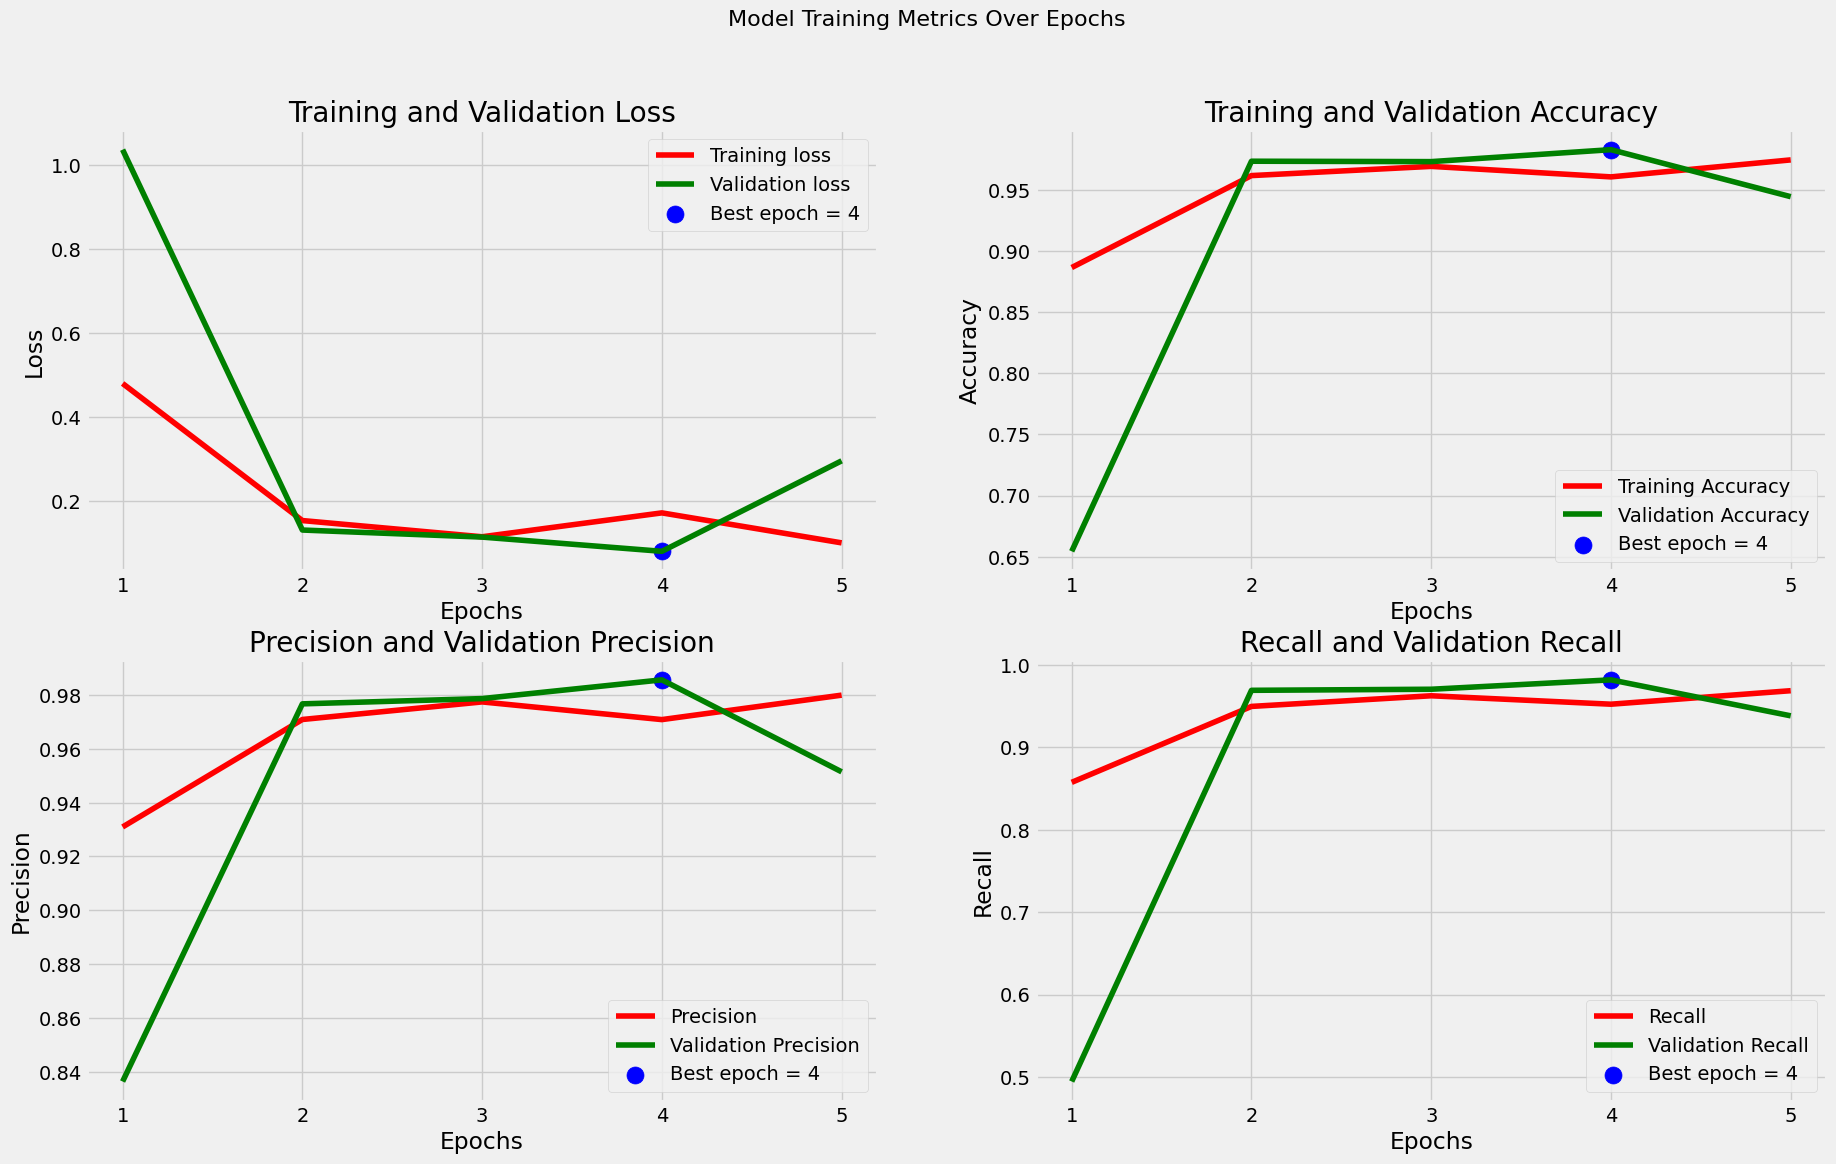

In [ ]:
tr_acc = hist.history['accuracy']
tr_loss = hist.history['loss']
tr_per = hist.history['precision']
tr_recall = hist.history['recall']
val_acc = hist.history['val_accuracy']
val_loss = hist.history['val_loss']
val_per = hist.history['val_precision']
val_recall = hist.history['val_recall']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
index_precision = np.argmax(val_per)
per_highest = val_per[index_precision]
index_recall = np.argmax(val_recall)
recall_highest = val_recall[index_recall]

Epochs = [i + 1 for i in range(len(tr_acc))]
loss_label = f'Best epoch = {str(index_loss + 1)}'
acc_label = f'Best epoch = {str(index_acc + 1)}'
per_label = f'Best epoch = {str(index_precision + 1)}'
recall_label = f'Best epoch = {str(index_recall + 1)}'

plt.figure(figsize=(20, 12))
plt.style.use('fivethirtyeight')

plt.subplot(2, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training loss')
plt.plot(Epochs, val_loss, 'g', label='Validation loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.xticks(np.arange(min(Epochs), max(Epochs)+1, 1.0))

plt.subplot(2, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.xticks(np.arange(min(Epochs), max(Epochs)+1, 1.0))

plt.subplot(2, 2, 3)
plt.plot(Epochs, tr_per, 'r', label='Precision')
plt.plot(Epochs, val_per, 'g', label='Validation Precision')
plt.scatter(index_precision + 1, per_highest, s=150, c='blue', label=per_label)
plt.title('Precision and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.xticks(np.arange(min(Epochs), max(Epochs)+1, 1.0))

plt.subplot(2, 2, 4)
plt.plot(Epochs, tr_recall, 'r', label='Recall')
plt.plot(Epochs, val_recall, 'g', label='Validation Recall')
plt.scatter(index_recall + 1, recall_highest, s=150, c='blue', label=recall_label)
plt.title('Recall and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)
plt.xticks(np.arange(min(Epochs), max(Epochs)+1, 1.0))

plt.suptitle('Model Training Metrics Over Epochs', fontsize=16)

plt.show()


In [ ]:
train_score = model.evaluate(tr_gen, verbose=1)
valid_score = model.evaluate(valid_gen, verbose=1)
test_score = model.evaluate(ts_gen, verbose=1)

print(f"Train Loss: {train_score[0]:.4f}")
print(f"Train Accuracy: {train_score[1]*100:.2f}%")
print('-' * 20)
print(f"Validation Loss: {valid_score[0]:.4f}")
print(f"Validation Accuracy: {valid_score[1]*100:.2f}%")
print('-' * 20)
print(f"Test Loss: {test_score[0]:.4f}")
print(f"Test Accuracy: {test_score[1]*100:.2f}%")

192/192 [==============================] - 3s 15ms/step - loss: 0.1826 - accuracy: 0.9567
Train Loss: 0.0430
Train Accuracy: 98.54%
--------------------
Validation Loss: 0.1670
Validation Accuracy: 95.93%
--------------------
Test Loss: 0.1826
Test Accuracy: 95.67%


In [ ]:
from keras.models import load_model

In [ ]:
saved_lenet_model = load_model('/content/drive/My Drive/LeNet_digit_model.h5')

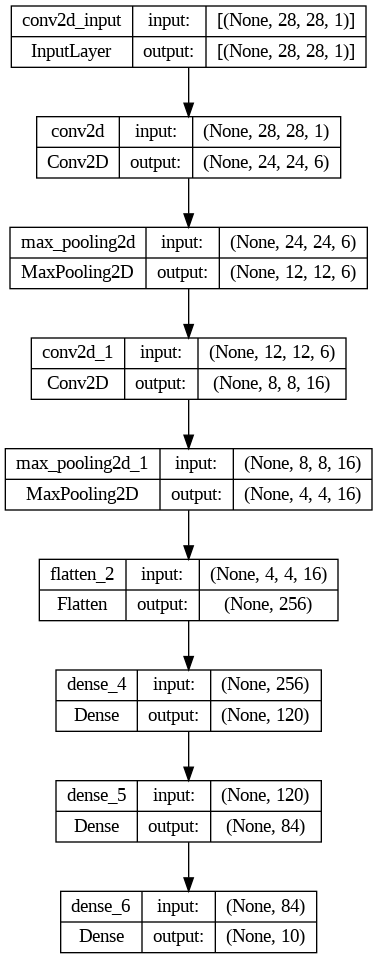

In [ ]:
tf.keras.utils.plot_model(saved_lenet_model, show_shapes=True)

In [ ]:
train_score = saved_lenet_model.evaluate(tr_gen, verbose=1)
valid_score = saved_lenet_model.evaluate(valid_gen, verbose=1)
test_score = saved_lenet_model.evaluate(ts_gen, verbose=1)

print(f"Train Loss: {train_score[0]:.4f}")
print(f"Train Accuracy: {train_score[1]*100:.2f}%")
print('-' * 20)
print(f"Validation Loss: {valid_score[0]:.4f}")
print(f"Validation Accuracy: {valid_score[1]*100:.2f}%")
print('-' * 20)
print(f"Test Loss: {test_score[0]:.4f}")
print(f"Test Accuracy: {test_score[1]*100:.2f}%")

192/192 [==============================] - 2s 8ms/step - loss: 0.1826 - accuracy: 0.9567
Train Loss: 0.0433
Train Accuracy: 98.52%
--------------------
Validation Loss: 0.1666
Validation Accuracy: 95.70%
--------------------
Test Loss: 0.1826
Test Accuracy: 95.67%


In [ ]:
preds = saved_lenet_model.predict(ts_gen)
y_pred = np.argmax(preds, axis=1)

192/192 [==============================] - 2s 8ms/step
